In [1]:
import numpy as np
import pandas as pd

from scipy.stats import norm, ttest_ind
from scipy.optimize import minimize_scalar

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import f_regression, mutual_info_regression, RFECV
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_log_error, make_scorer, mean_squared_error
from sklearn import preprocessing
from sklearn.feature_selection import RFE
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

**Load homework_data.csv.**

In [2]:
df = pd.read_csv('homework_data.csv')

**Analyze the distribution of 'price' and try to transform it into normal distibution.**

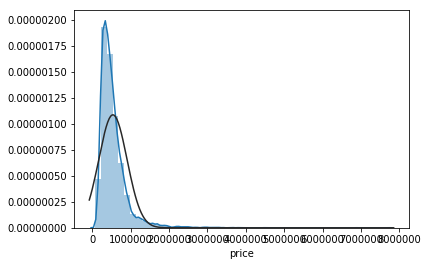

In [3]:
sns.distplot(df.price, fit=norm)

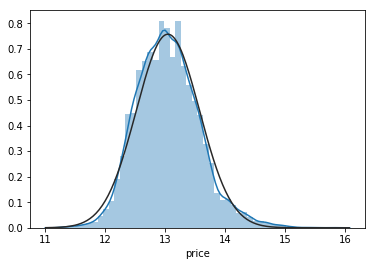

In [4]:
sns.distplot(np.log1p(df.price), fit=norm)

In [5]:
df.price = np.log1p(df.price)

In [6]:
df.head(3)

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,has_sqft_above,sqft_above2,has_sqft_basement,sqft_basement2,has_sqft_living15,sqft_living152,has_sqft_lot15,sqft_lot152,has_sqft_all,sqft_all2
0,0,7129300520,20141013T000000,12.309987,3,1.00,1180,5650,1.0,0,...,1,34.351128,0,0.0,1,36.606010,1,75.166482,1,122.474487
1,1,6414100192,20141209T000000,13.195616,3,2.25,2570,7242,2.0,0,...,1,46.583259,1,20.0,1,41.109610,1,87.401373,1,147.346530
2,2,5631500400,20150225T000000,12.100718,2,1.00,770,10000,1.0,0,...,1,27.748874,0,0.0,1,52.153619,1,89.788641,1,149.405489


In [7]:
# Date is unuseful. It will be better to remove it before convert categorical variable into dummy/indicator variables
df.drop(['date'], axis = 1, errors = 'ignore', inplace = True)

In [8]:
display(df.select_dtypes(include=['object']).nunique().nlargest(5))

Series([], dtype: float64)

In [9]:
df = pd.get_dummies(df)

In [10]:
# Remove constant features
display(df.columns[df.min() == df.max()])
df = df[df.columns[df.min() != df.max()]]

Index(['has_sqft_living', 'has_sqft_lot', 'has_sqft_above',
       'has_sqft_living15', 'has_sqft_lot15', 'has_sqft_all'],
      dtype='object')

In [11]:
# collect type column names
continuous_columns = df.select_dtypes(include=['float64']).columns
discrete_columns = df.select_dtypes(include=['int64']).columns
indicator_columns = df.select_dtypes(include=['uint8']).columns

In [12]:
dt, dtest = train_test_split(df, test_size=0.25, random_state=17)
dt = dt.copy()
dtest = dtest.copy()

In [13]:
print('Train: ', len(dt), '; Test: ', len(dtest))

Train:  16209 ; Test:  5404


In [14]:
# Standardize scaling
scaler = preprocessing.StandardScaler()

# Prepare column names - ['float64', 'int64', 'uint8']
columns = dt.select_dtypes(include=['float64', 'int64']).columns
columns = columns.drop('SalePrice', errors = 'ignore')
print(list(columns))

# Prepare values for transform
scaler.fit(dt[columns])

# Transform
dt[columns] = scaler.transform(dt[columns])
dtest[columns] = scaler.transform(dtest[columns])

['Unnamed: 0', 'id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sqft_all', 'rcprice', 'has_wine_bar', 'garage_type', 'sqft_living2', 'sqft_lot2', 'sqft_above2', 'has_sqft_basement', 'sqft_basement2', 'sqft_living152', 'sqft_lot152', 'sqft_all2']


In [15]:
dt.head(2)

,Unnamed: 0,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,has_wine_bar,garage_type,sqft_living2,sqft_lot2,sqft_above2,has_sqft_basement,sqft_basement2,sqft_living152,sqft_lot152,sqft_all2
8966,-0.293969,-0.623324,1.158846,2.807702,2.122340,1.174956,-0.241864,0.934155,-0.084901,-0.303682,...,-0.993911,1.086322,1.217658,-0.437657,1.632769,-0.805251,-0.756036,-0.302242,-0.466919,-0.341588
9474,-0.212573,1.196147,0.972985,1.737960,-0.799189,0.087077,-0.241864,0.009526,-0.084901,2.322987,...,-0.993911,1.086322,0.196876,-0.437657,0.567880,-0.805251,-0.756036,-0.797366,-0.561289,-0.478417


**Feature selection**

In [16]:
# Drop Unnamed: 0
dt.drop(['id'], axis = 1, errors = 'ignore', inplace = True)
dtest.drop(['id'], axis = 1, errors = 'ignore', inplace = True)

In [17]:
# Drop Id
dt.drop(['Unnamed: 0'], axis = 1, errors = 'ignore', inplace = True)
dtest.drop(['Unnamed: 0'], axis = 1, errors = 'ignore', inplace = True)

In [18]:
# Find features with low variance
columns_to_remove = dt.columns[dt.var() < 0.02]
dt[columns_to_remove].var().nlargest(5)
print(len(columns_to_remove))

0


In [19]:
# Perform t-test with indicator variables - calculate p-values
ttest_pvals = df\
    .drop(columns_to_remove, axis = 1, errors = 'ignore')\
    .select_dtypes(include = ['uint8']).columns\
    .to_series()\
    .apply(lambda x: ttest_ind(df.SalePrice[df[x] == 0], df.SalePrice[df[x] == 1], equal_var = False).pvalue)


In [20]:
columns_to_remove = list(set(columns_to_remove).union(set(ttest_pvals[ttest_pvals > 0.5].index)))
print(len(columns_to_remove))

0


**Correlation approach**

In [21]:
corrP = dt.drop(columns_to_remove, axis = 1, errors = 'ignore').corr(method='pearson')
corrS = dt.drop(columns_to_remove, axis = 1, errors = 'ignore').corr(method='spearman')

In [55]:
corrP_cols = corrP.price.abs().nlargest(13).index
corrS_cols = corrS.price.abs().nlargest(13).index

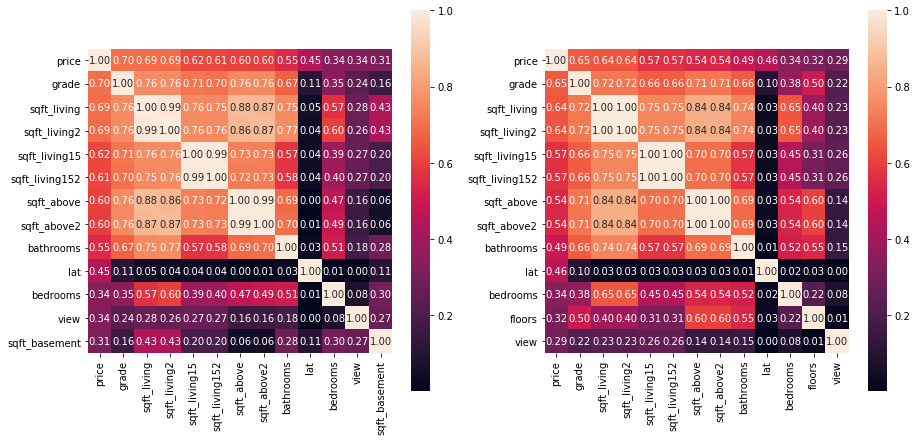

In [56]:
fig, axs = plt.subplots(ncols=2, figsize=(15,7))
sns.heatmap(corrP.abs().loc[corrP_cols,corrP_cols],ax=axs[0], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=corrP_cols.values, xticklabels=corrP_cols.values)
sns.heatmap(corrS.abs().loc[corrS_cols,corrS_cols],ax=axs[1], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=corrS_cols.values, xticklabels=corrS_cols.values)

**Subset selection**

In [57]:
X = dt.drop(['price'], axis = 1, errors = 'ignore')
y = dt.price

# calculate F values for correlation coefficient (calculated from rho using an increasing function)
# calculate p-values of the correspondong F-test (inversely proportional to rho)
Fscores, pvals = f_regression(X,y)
print(max(pvals))

0.897744459267


In [58]:
mi = mutual_info_regression(X,y)
display(pd.Series(mi, index=X.columns).nlargest(5))

zipcode         0.396009
sqft_living2    0.350333
sqft_living     0.348426
grade           0.335573
lat             0.327415
dtype: float64

In [69]:
# Feature ranking with recursive feature elimination and cross-validated selection of the best number of features.
used_columns = X.columns

def scorer(Y, yp):
    return np.sqrt(mean_squared_error(Y, yp))

clfM = LinearRegression()

selector = RFECV(clfM, step=1, cv=5, scoring=make_scorer(scorer))
selector = selector.fit(X, y)

In [71]:
# I tried to use another feature selector because with RFECV it selects only one feature.
# RFE Feature ranking with recursive feature elimination.
from sklearn.feature_selection import RFE
selector_rfe = RFE(clfM, step=1)
selector_rfe = selector_rfe.fit(X, y)

In [72]:
# with RFECL
result = pd.DataFrame({'Chosen': selector.support_, 'Ranking': selector.ranking_}, index=list(used_columns))
# columns to leave
columns_to_leave = result[result.Chosen == True].index
# show results
display(result.Chosen.sum())

1

In [82]:
# with RFE


15

In [85]:
columns_to_leave_rfe

Index(['bathrooms', 'view', 'grade', 'sqft_basement', 'yr_built', 'lat',
       'sqft_living15', 'sqft_living2', 'sqft_lot2', 'sqft_above2',
       'has_sqft_basement', 'sqft_basement2', 'sqft_living152', 'sqft_lot152',
       'sqft_all2'],
      dtype='object')

**Estimation - Linear Regression**

Root mean squared logarithmic error: 0.470030019345


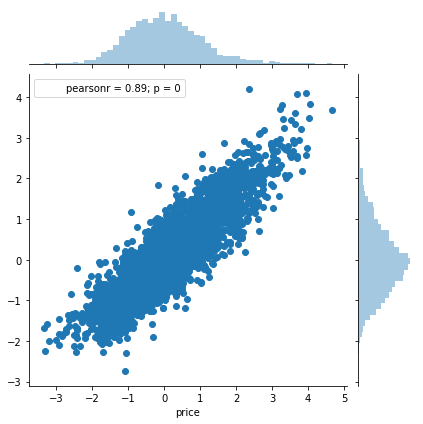

In [30]:
# Data prepare with all features
X = dt.drop(['price'], axis = 1, errors = 'ignore')
y = dt.price
Xtest = dtest.drop(['price'], axis = 1, errors = 'ignore')
ytest = dtest.price

# Linear Regression
clf1 = LinearRegression()
clf1.fit(X, y) 

# Print RMSLE
print('Root mean squared logarithmic error:', np.sqrt(mean_squared_error(clf1.predict(Xtest), ytest)))
# Joint Plot
sns.jointplot(ytest, clf1.predict(Xtest))

Root mean squared logarithmic error: 1.00446694618


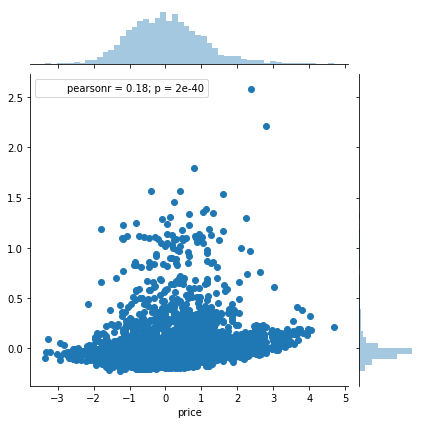

In [36]:
# Data prepare with selected subset (only one feature - sqft_all2)
X = dt[columns_to_leave].drop(['price'], axis = 1, errors = 'ignore')
y = dt.price
Xtest = dtest[columns_to_leave].drop(['price'], axis = 1, errors = 'ignore')
ytest = dtest.price

# Linear Regression
clf1 = LinearRegression()
clf1.fit(X, y) 

# Print RMSLE
print('Root mean squared logarithmic error:', np.sqrt(mean_squared_error(clf1.predict(Xtest), ytest)))
# Joint Plot
sns.jointplot(ytest, clf1.predict(Xtest))

Root mean squared logarithmic error: 0.484841164799


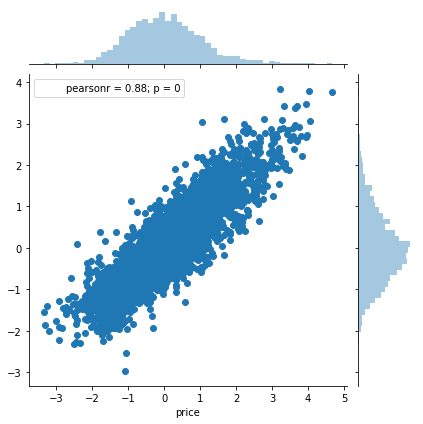

In [86]:
# Data prepare with selected subset (ranked by RFE)
X = dt[columns_to_leave_rfe].drop(['price'], axis = 1, errors = 'ignore')
y = dt.price
Xtest = dtest[columns_to_leave_rfe].drop(['price'], axis = 1, errors = 'ignore')
ytest = dtest.price

# Linear Regression
clf1 = LinearRegression()
clf1.fit(X, y) 

# Print RMSLE
print('Root mean squared logarithmic error:', np.sqrt(mean_squared_error(clf1.predict(Xtest), ytest)))
# Joint Plot
sns.jointplot(ytest, clf1.predict(Xtest))